# Quickstart

`geoplot` is a geospatial data visualization library designed for data scientists and geospatial analysts that just want to get things done. In this tutorial we will learn the basics of `geoplot` and see how it is used.

You can run this tutorial code yourself interactively using [Binder](https://mybinder.org/v2/gh/ResidentMario/geoplot/master?filepath=notebooks/tutorials/Quickstart.ipynb).

In [1]:
# Configure matplotlib.
%matplotlib inline

# Unclutter the display.
import pandas as pd; pd.set_option('max_columns', 6)

## Working with geospatial data

The starting point for geospatial analysis is geospatial data. The standard way of dealing with such data in Python using `geopandas`&mdash;a geospatial data parsing library over the well-known `pandas` library.

In [2]:
import geopandas as gpd

`geopandas` represents data using a `GeoDataFrame`, which is just a `pandas` `DataFrame` with a special `geometry` column containing a geometric object describing the physical nature of the record in question: a `POINT` in space, a `POLYGON` in the shape of New York, and so on.

In [3]:
import geoplot as gplt
usa_cities = gpd.read_file(gplt.datasets.get_path('usa_cities'))
usa_cities.head()

,id,POP_2010,ELEV_IN_FT,STATE,geometry
0,53,40888.0,1611.0,ND,POINT (-101.2962732 48.23250950000011)
1,101,52838.0,830.0,ND,POINT (-97.03285469999997 47.92525680000006)
2,153,15427.0,1407.0,ND,POINT (-98.70843569999994 46.91054380000003)
3,177,105549.0,902.0,ND,POINT (-96.78980339999998 46.87718630000012)
4,192,17787.0,2411.0,ND,POINT (-102.7896241999999 46.87917560000005)


<div style="margin-top:2em">
All functions in `geoplot` take a `GeoDataFrame` as input.

> Note that `shapely`, the library `geopandas` uses to store its geometries, uses "modern" longitude-latitude `(x, y)` coordinate order. This differs from the "historical" latitude-longitude `(y, x)` coordinate order. Datasets "in the wild" may be in either format, so after reading in some data make sure to verify that your coordinates are in the right order!
</div>

## Basic usage

If you have ever worked with `geopandas` before you are probably familiar with `plot`, which can be used to quickly and easily plot the data in a `GeoDataFrame`:

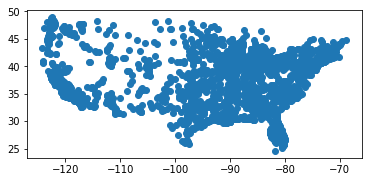

In [4]:
continental_usa_cities = usa_cities.query('STATE not in ["HI", "AK", "PR"]')
continental_usa_cities.plot()

We can replicate this result with nicer defaults using the `pointplot` function in `geoplot`:

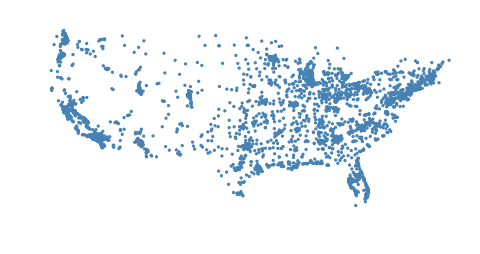

In [5]:
import geoplot as gplt
gplt.pointplot(continental_usa_cities)

If you have polygonal data instead, you can plot that using a `geoplot` `polyplot`.

In [6]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

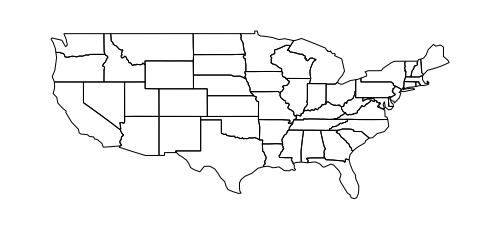

In [7]:
gplt.polyplot(contiguous_usa)

We can combine the these two plots using overplotting. **Overplotting** is the act of stacking several different plots on top of one another, useful for providing additional context for our plots:

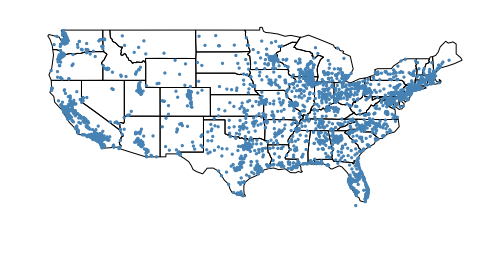

In [8]:
ax = gplt.polyplot(contiguous_usa)
gplt.pointplot(continental_usa_cities, ax=ax)

You might notice that this map of the United States looks very strange. The Earth, being a sphere, is impossible to potray in two dimensionals. Hence, whenever we take data off the sphere and place it onto a map, we are using some kind of **projection**, or method of flattening the sphere. Plotting data without a projection, or "carte blanche", creates distortion in your map. We can "fix" the distortion by picking a better projection.

The Albers equal area projection is one most common in the United States. Here's how you use it with `geoplot`:

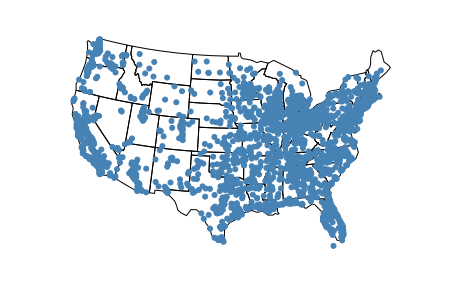

In [9]:
import geoplot.crs as gcrs

proj = gcrs.AlbersEqualArea()
ax = gplt.polyplot(contiguous_usa, projection=proj)
gplt.pointplot(continental_usa_cities, ax=ax, projection=proj)

This looks much better than our first plot! In fact, this is the version of the United States that you'll probably most often see in maps; and it's just one of dozens of projections provided in `geoplot`.

To learn more about projections check out the section of the tutorial on [Working with Projection](https://nbviewer.jupyter.org/github/ResidentMario/geoplot/blob/master/notebooks/tutorials/Working%20with%20Projections.ipynb).

What if you want to make your plot prettier? `geoplot` has tons of options for doing so, courtesy of `matplotlib`:

/Users/alex/miniconda3/envs/geoplot-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Cities in the contiguous United States, 2010')

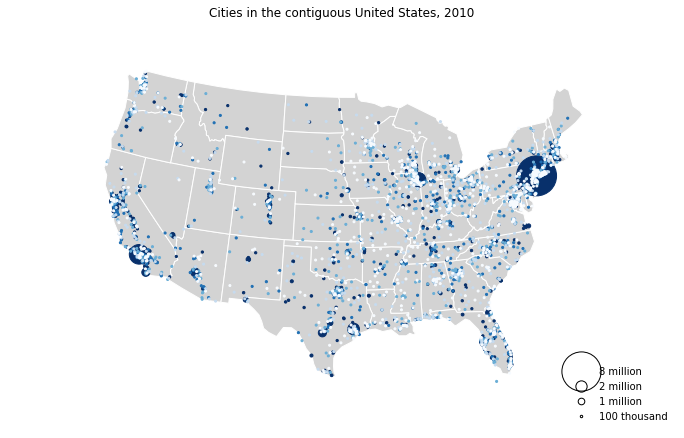

In [12]:
import matplotlib.pyplot as plt

proj = gcrs.AlbersEqualArea()

ax = gplt.polyplot(
    contiguous_usa, 
    zorder=-1,  # place the state shapes below the cities.
    linewidth=1,
    projection=proj,
    edgecolor='white',
    facecolor='lightgray',
    figsize=(12, 12)  # make the figure bigger.
)

gplt.pointplot(
    continental_usa_cities, 
    scale='POP_2010',  # set point size based on population
    limits=(2, 40),    # scale points from 1x to 80x
    hue='POP_2010',    # Changing the color with population, too...
    cmap='Blues',      # ...more blue, more people...
    k=5,               # but let's limit ourselves to just five "classes" of city sizes
    legend=True,       # Show a legend based on circle size, with the following values
    legend_var='scale',
    legend_values=[8000000, 2000000, 1000000, 100000],
    legend_labels=['8 million', '2 million', '1 million', '100 thousand'],
    legend_kwargs={'frameon': False, 'loc': 'lower right'},
    ax=ax, 
    projection=proj
)

plt.title("Cities in the contiguous United States, 2010")  # add a title

For a detailed guide to the plot customization options available in `geoplot`, check out the section of the tutorial on Customizing Plots.

## More plotting options

`geoplot` is organized in terms of **plots**. There are many different different plot types, each of which has strengths, weaknesses, and expected data types.

We have seen two so far: `polyplot` and `pointplot`.

`polyplot` is the simplest plot in `geoplot`. It takes polygonal data (a `GeoDataFrame` with `POLYGON` or `MULTIPOLYGON` objects in the `geometry` column) as input, and provides a map of those polygons as output. It is used for adding a **basemap** to your visualiaztion: a representation of the space which adds context to the data you are actually trying to display.

`pointplot` is a geospatial scatter plot. It takes point data (a `GeoDataFrame` with `POINT` objects in the `geometry` column) as input, and provides a map of those points as output. If your data consists of a set of points, this plot type is a good fist choice: it's easy, obviously, and easily explainable.

To browse the other plot types, check out the Plot Reference or the Gallery.

## What to do next

You should now know enough `geoplot` to try it out in your own projects.

To install `geoplot`, run `conda install geoplot`. To keep learning about `geoplot` and geospatial plotting, refer to the User Guide. Finally, the API Reference is the definitive guide all of to the options available for the plot types in `geoplot`.